In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as mpl
import plot_utils

In [2]:
methods = {
    # 'n_3r1i': '3 dims\n1 answer',
    # 'n_1r1i': '1 dim\n1 answer',
    'n_1r10i': '1 dim\n10 answers',
    'n_1r20i': '1 dim\n20 answers',
    'n_1r50i': '1 dim\n50 answers',
    's_1r20i': '1 dim\n20 answers\n10 samples',
    # 'n_1r20i_numeric': '1 dim\n20 answers\nrating-only',
    # 's_1r20i_numeric': '1 dim\n20 answers\nrating-only\n10 samples',
}

In [3]:
comparisons = {
    ('n_1r1i', 'n_3r1i'): 'Number of dimensions',
    ('n_1r1i', 'n_1r10i', 'n_1r20i', 'n_1r50i'): 'Number of answers',
    ('n_1r20i', 's_1r20i', 'n_1r20i_numeric', 's_1r20i_numeric'): 'Samples and rating-only prompts'
}

short_titles = {
    'Number of dimensions': '# dimensions',
    'Number of answers': '# answers',
    'Samples and rating-only prompts': 'Samples / rating-only'
}

In [4]:
measures = ('novelty', 'feasibility', 'value')

In [5]:
pearson = pd.DataFrame(columns=measures, dtype=float)
spearman = pd.DataFrame(columns=measures, dtype=float)

In [6]:
squid = []
rmsd = []
for method, name in methods.items():
    data = pd.read_excel(f'gpt-ratings/{method}-turbo.xlsx')
    for key in measures:
        if key == 'value':
            mask = (data[key]>0) & (data[key]<100_000)
        else:
            mask = data.index>=0
        spearman.loc[name, key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic
        pearson.loc[name, key] = stats.pearsonr(data[mask][key.capitalize()], data[mask][key]).statistic

    for qid in data['Question id'].unique():
        qmask = data['Question id'] == qid
        entry = {'method': name}
        rmsd_entry = {'method': name}
        for key in measures:
            mask = qmask
            if key == 'value':
                mask &= (data[key]>0) & (data[key]<100_000)

            entry[key] = stats.spearmanr(data[mask][[key.capitalize(), key]]).statistic

            x = data[mask][key.capitalize()]
            x_rank = np.empty(x.shape, int)
            x_rank[np.argsort(x)] = np.arange(len(x))

            y = data[mask][key]
            y_rank = np.empty(y.shape, int)
            y_rank[np.argsort(y)] = np.arange(len(y))

            rmsd_entry[key] = np.sqrt(np.mean(np.square(y_rank - x_rank)))

        squid.append(entry)
        rmsd.append(rmsd_entry)
spearman_qid = pd.DataFrame(squid)
rmsd = pd.DataFrame(rmsd)

Text(0, 0.5, '')

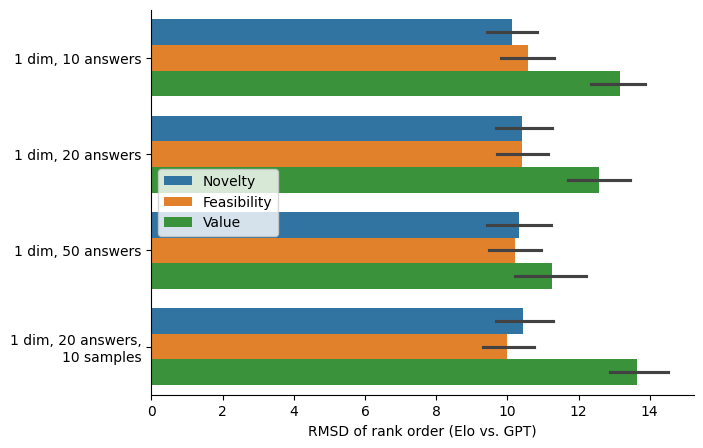

In [7]:
plt.figure(figsize=(7,5))
long = rmsd.set_index('method').melt(value_name='RMSD of rank order (Elo vs. GPT)', var_name='measure', ignore_index=False)
long.index = [s.replace('\n',', ').replace('answers, ','answers,\n') for s in long.index]
ax = sns.barplot(long, y=long.index, x='RMSD of rank order (Elo vs. GPT)', hue='measure')
plt.legend(ax.containers, [m.capitalize() for m in measures], loc='center left')
sns.despine()
plt.ylabel('')

In [8]:
pearson

,novelty,feasibility,value
1 dim\n10 answers,0.586729,0.529324,0.158902
1 dim\n20 answers,0.545021,0.547986,0.161774
1 dim\n50 answers,0.524144,0.551987,0.146895
1 dim\n20 answers\n10 samples,0.546258,0.576869,0.136647


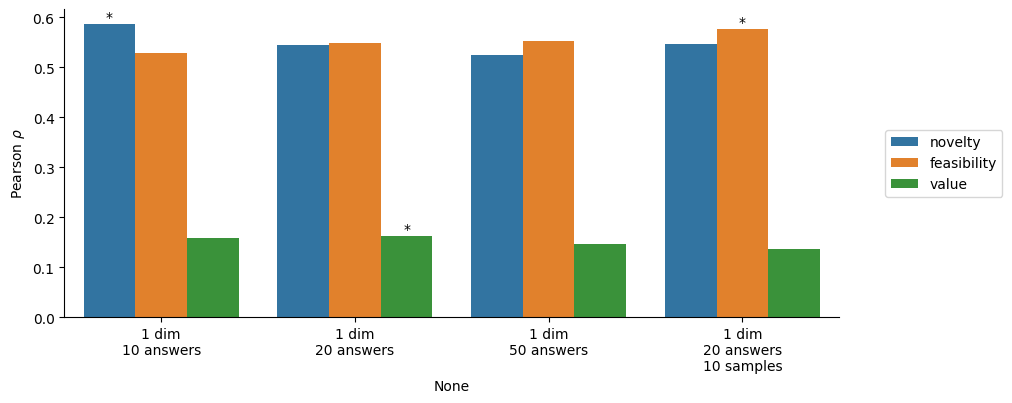

In [9]:
fig, ax = plt.subplots(figsize=(10,4))

long = pearson.melt(value_name='correlation', var_name='measure', ignore_index=False)

imax = [i*len(pearson) + pearson[col].astype('float').argmax() for i, col in enumerate(pearson.columns)]
labels = ['*' if i in imax else '' for i in range(len(long))]

sns.barplot(long, x=long.index, y='correlation', hue='measure', ax=ax)
for i, col in enumerate(pearson.columns):
    jmax = pearson[col].astype('float').argmax()
    labels = ['*' if j == jmax else '' for j in range(len(pearson))]
    ax.bar_label(ax.containers[i], labels)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
ax.set_ylabel('Pearson $\\rho$')
sns.despine(ax=ax)


In [10]:
spearman

,novelty,feasibility,value
1 dim\n10 answers,0.599195,0.563990,0.225352
1 dim\n20 answers,0.573114,0.582324,0.209022
1 dim\n50 answers,0.557837,0.594829,0.217460
1 dim\n20 answers\n10 samples,0.584326,0.609245,0.162272


In [13]:
mean = spearman_qid.groupby('method').mean()

In [14]:
std = spearman_qid.groupby('method').std()

In [15]:
print('\t'.join(['Method'] + [m.capitalize() for m in measures]))
for method in methods.values():
    m = method.replace('\n', ', ')
    print(m, end='')
    for measure in measures:
        mean_, sd_ = mean.loc[method, measure], std.loc[method, measure]
        print(f'\t{mean_:.2f}\t{sd_:.2f}\t{mean_/sd_:.2f}', end='')
    print()

Method	Novelty	Feasibility	Value
1 dim, 10 answers	0.62	0.13	4.95	0.59	0.14	4.15	0.26	0.18	1.41
1 dim, 20 answers	0.60	0.15	4.10	0.59	0.15	3.83	0.26	0.18	1.48
1 dim, 50 answers	0.61	0.14	4.32	0.61	0.16	3.87	0.30	0.20	1.51
1 dim, 20 answers, 10 samples	0.60	0.14	4.32	0.63	0.13	4.77	0.21	0.22	0.92


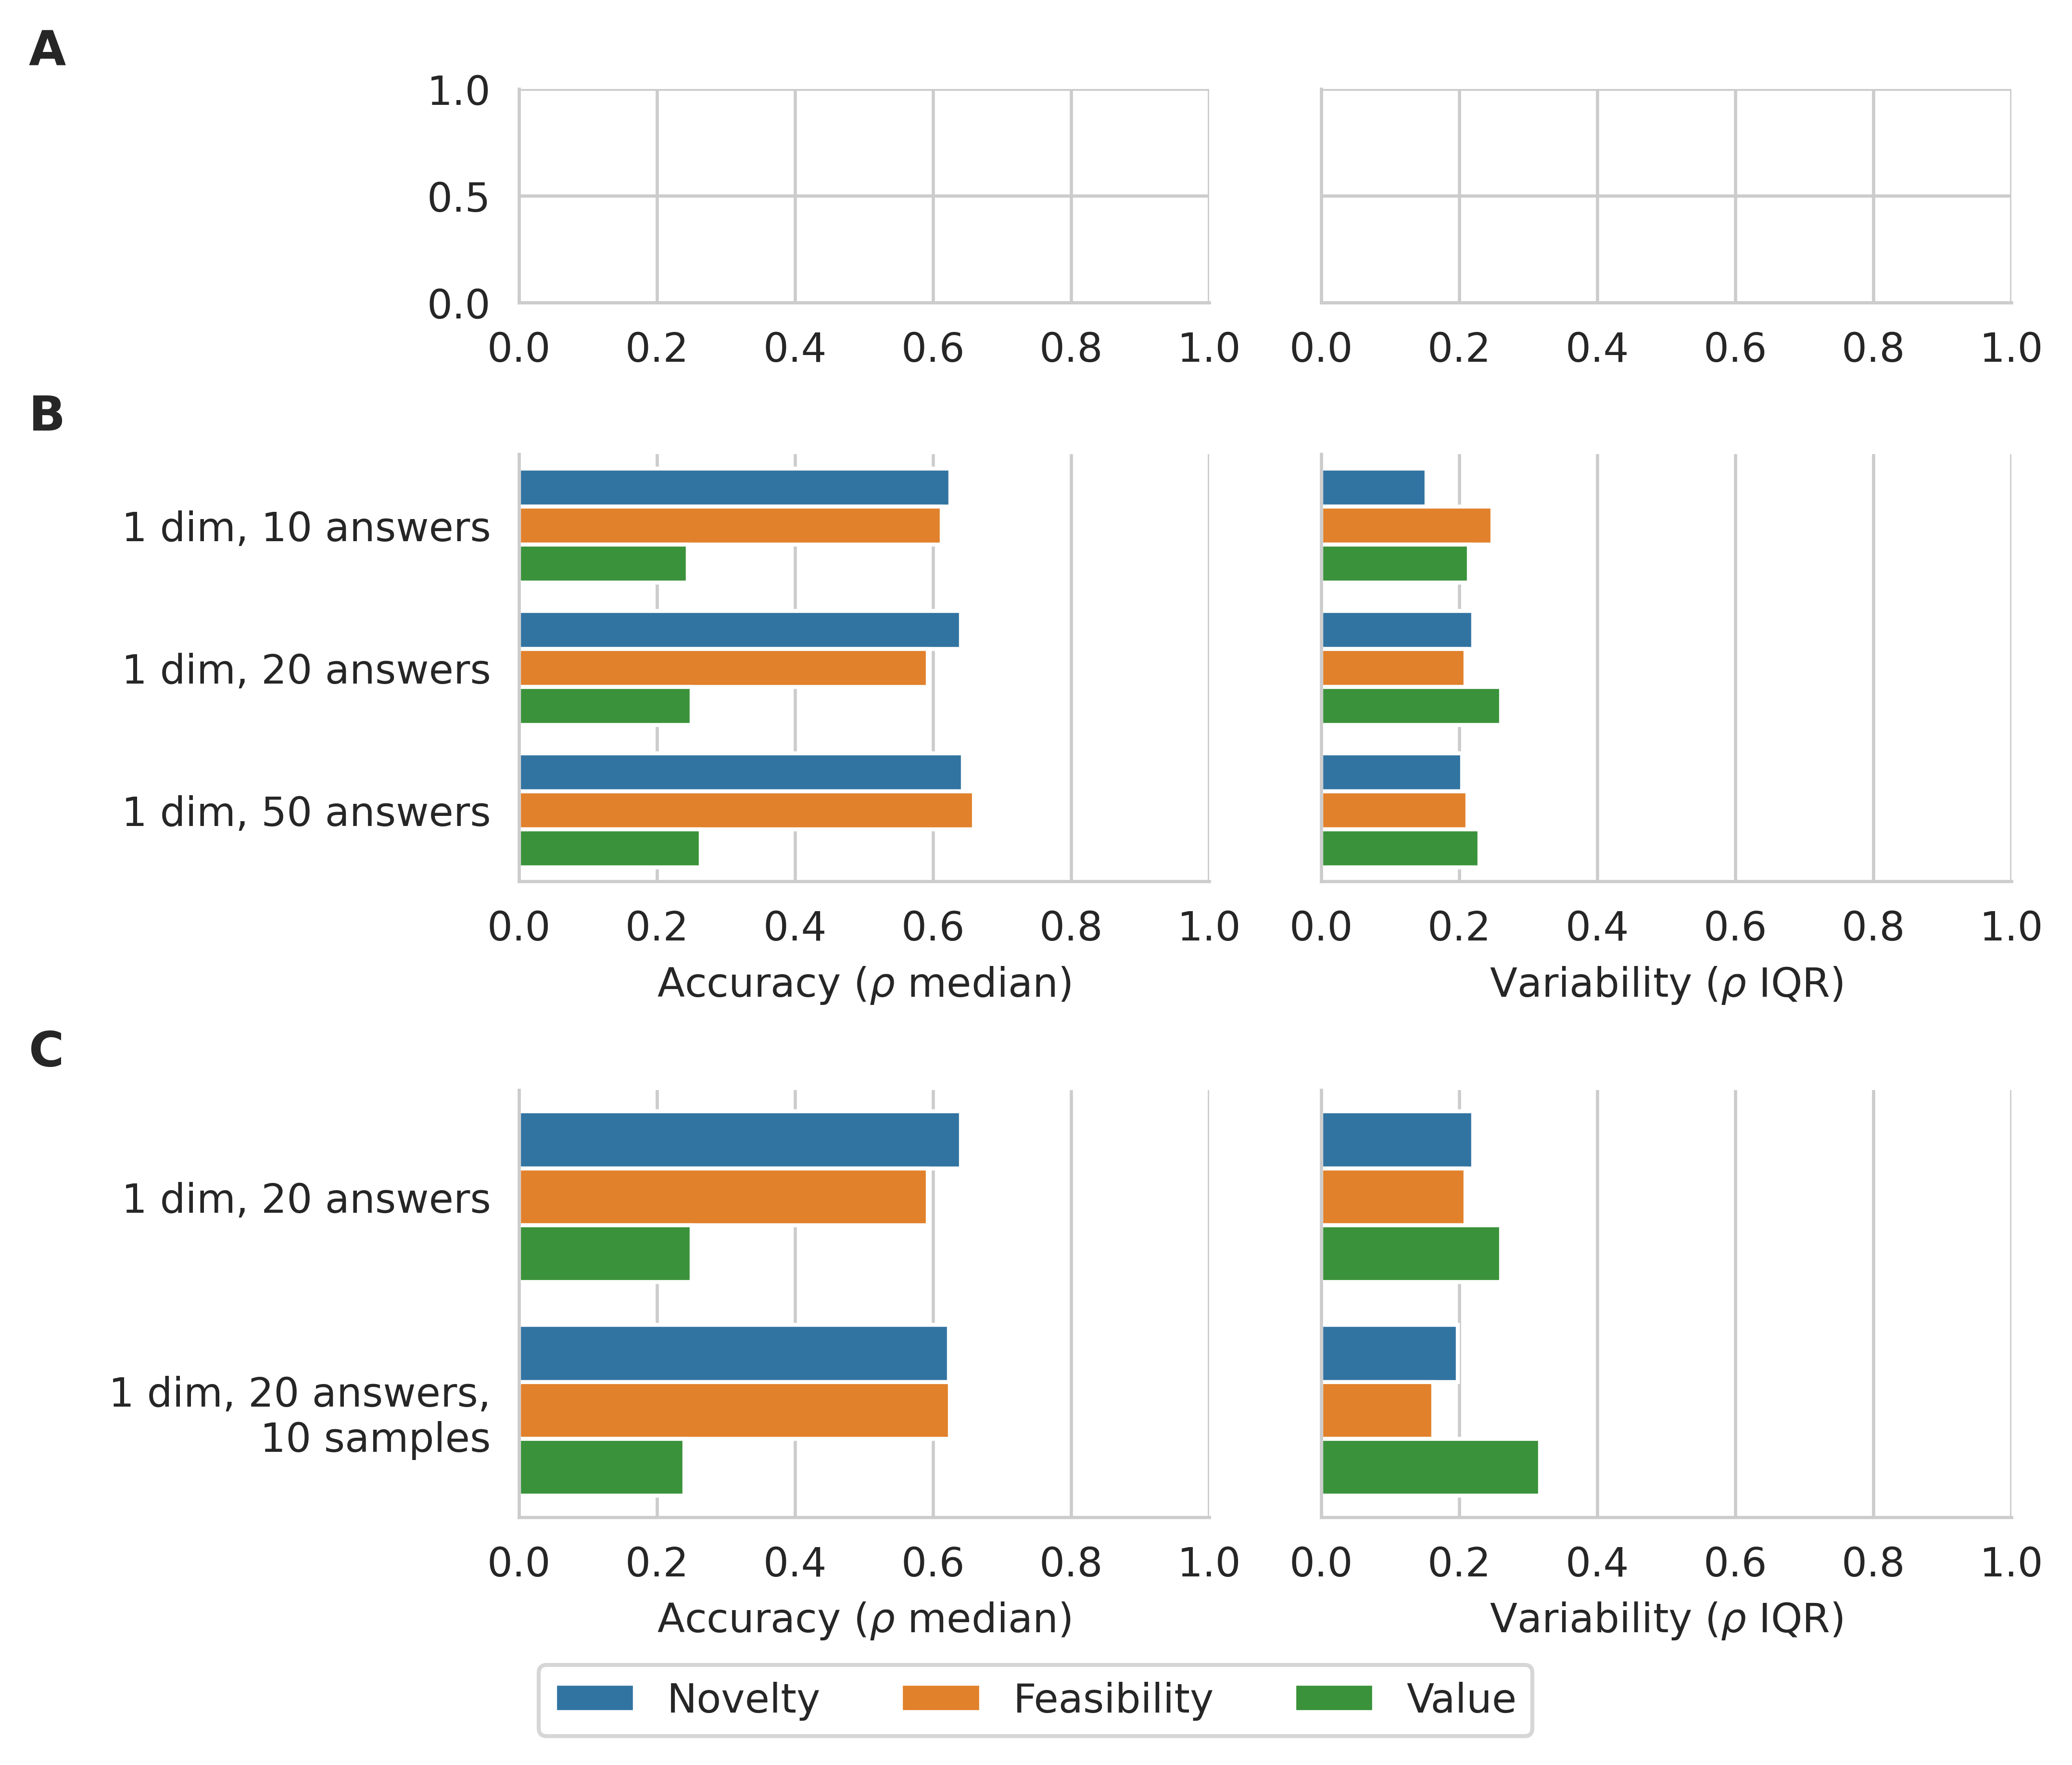

In [18]:
fig, axdict = plt.subplot_mosaic('ab\ncd\nef\nLL', height_ratios=(1,2,2,.2), figsize=(7,6), layout='constrained', dpi=600)
axs = np.asarray([[axdict[a], axdict[b]] for a,b in ('ab', 'cd', 'ef')])

medians = spearman_qid.groupby('method').median().loc[list(methods.values())].melt(value_name='Accuracy ($\\rho$ median)', var_name='measure', ignore_index=False)
iqr = spearman_qid.groupby('method').quantile(.75) - spearman_qid.groupby('method').quantile(.25)
iqr = iqr.loc[list(methods.values())].melt(value_name='Variability ($\\rho$ IQR)', var_name='measure', ignore_index=False)

for irow, (axr, (comp, title)) in enumerate(zip(axs, comparisons.items())):
    plot_utils.label_panel(axr[0], irow, left=5.5)

    rmedians = medians.loc[[methods[m] for m in comp if m in methods]].copy()
    rmedians.index = [s.replace('\n',', ').replace('answers, ','answers,\n') for s in rmedians.index]
    sns.barplot(rmedians, y=rmedians.index, x='Accuracy ($\\rho$ median)', hue='measure', ax=axr[0])
    
    riqr = iqr.loc[[methods[m] for m in comp if m in methods]]
    sns.barplot(riqr, y=riqr.index, x='Variability ($\\rho$ IQR)', hue='measure', ax=axr[1])
    axr[1].set_yticklabels([])

    # axr[0].set_title(title, loc='left')
    # for ax in axr:
    #     ax.set_title(short_titles[title])

for axc in axs.T:
    for ax in axc:
        ax.set_xlim(right=max([x.get_xlim()[1] for x in axc]))
        
        ax.set_ylabel('')
        sns.despine(ax=ax)

        bars = ax.containers
        for method in ax.get_children():
            if isinstance(method, mpl.legend.Legend):
                method.set_visible(False)

sns.despine(ax=axdict['L'], bottom=True, left=True)
axdict['L'].set_xticks([])
axdict['L'].set_yticks([])
axdict['L'].legend(bars, [m.capitalize() for m in measures], loc='center left', ncol=3)

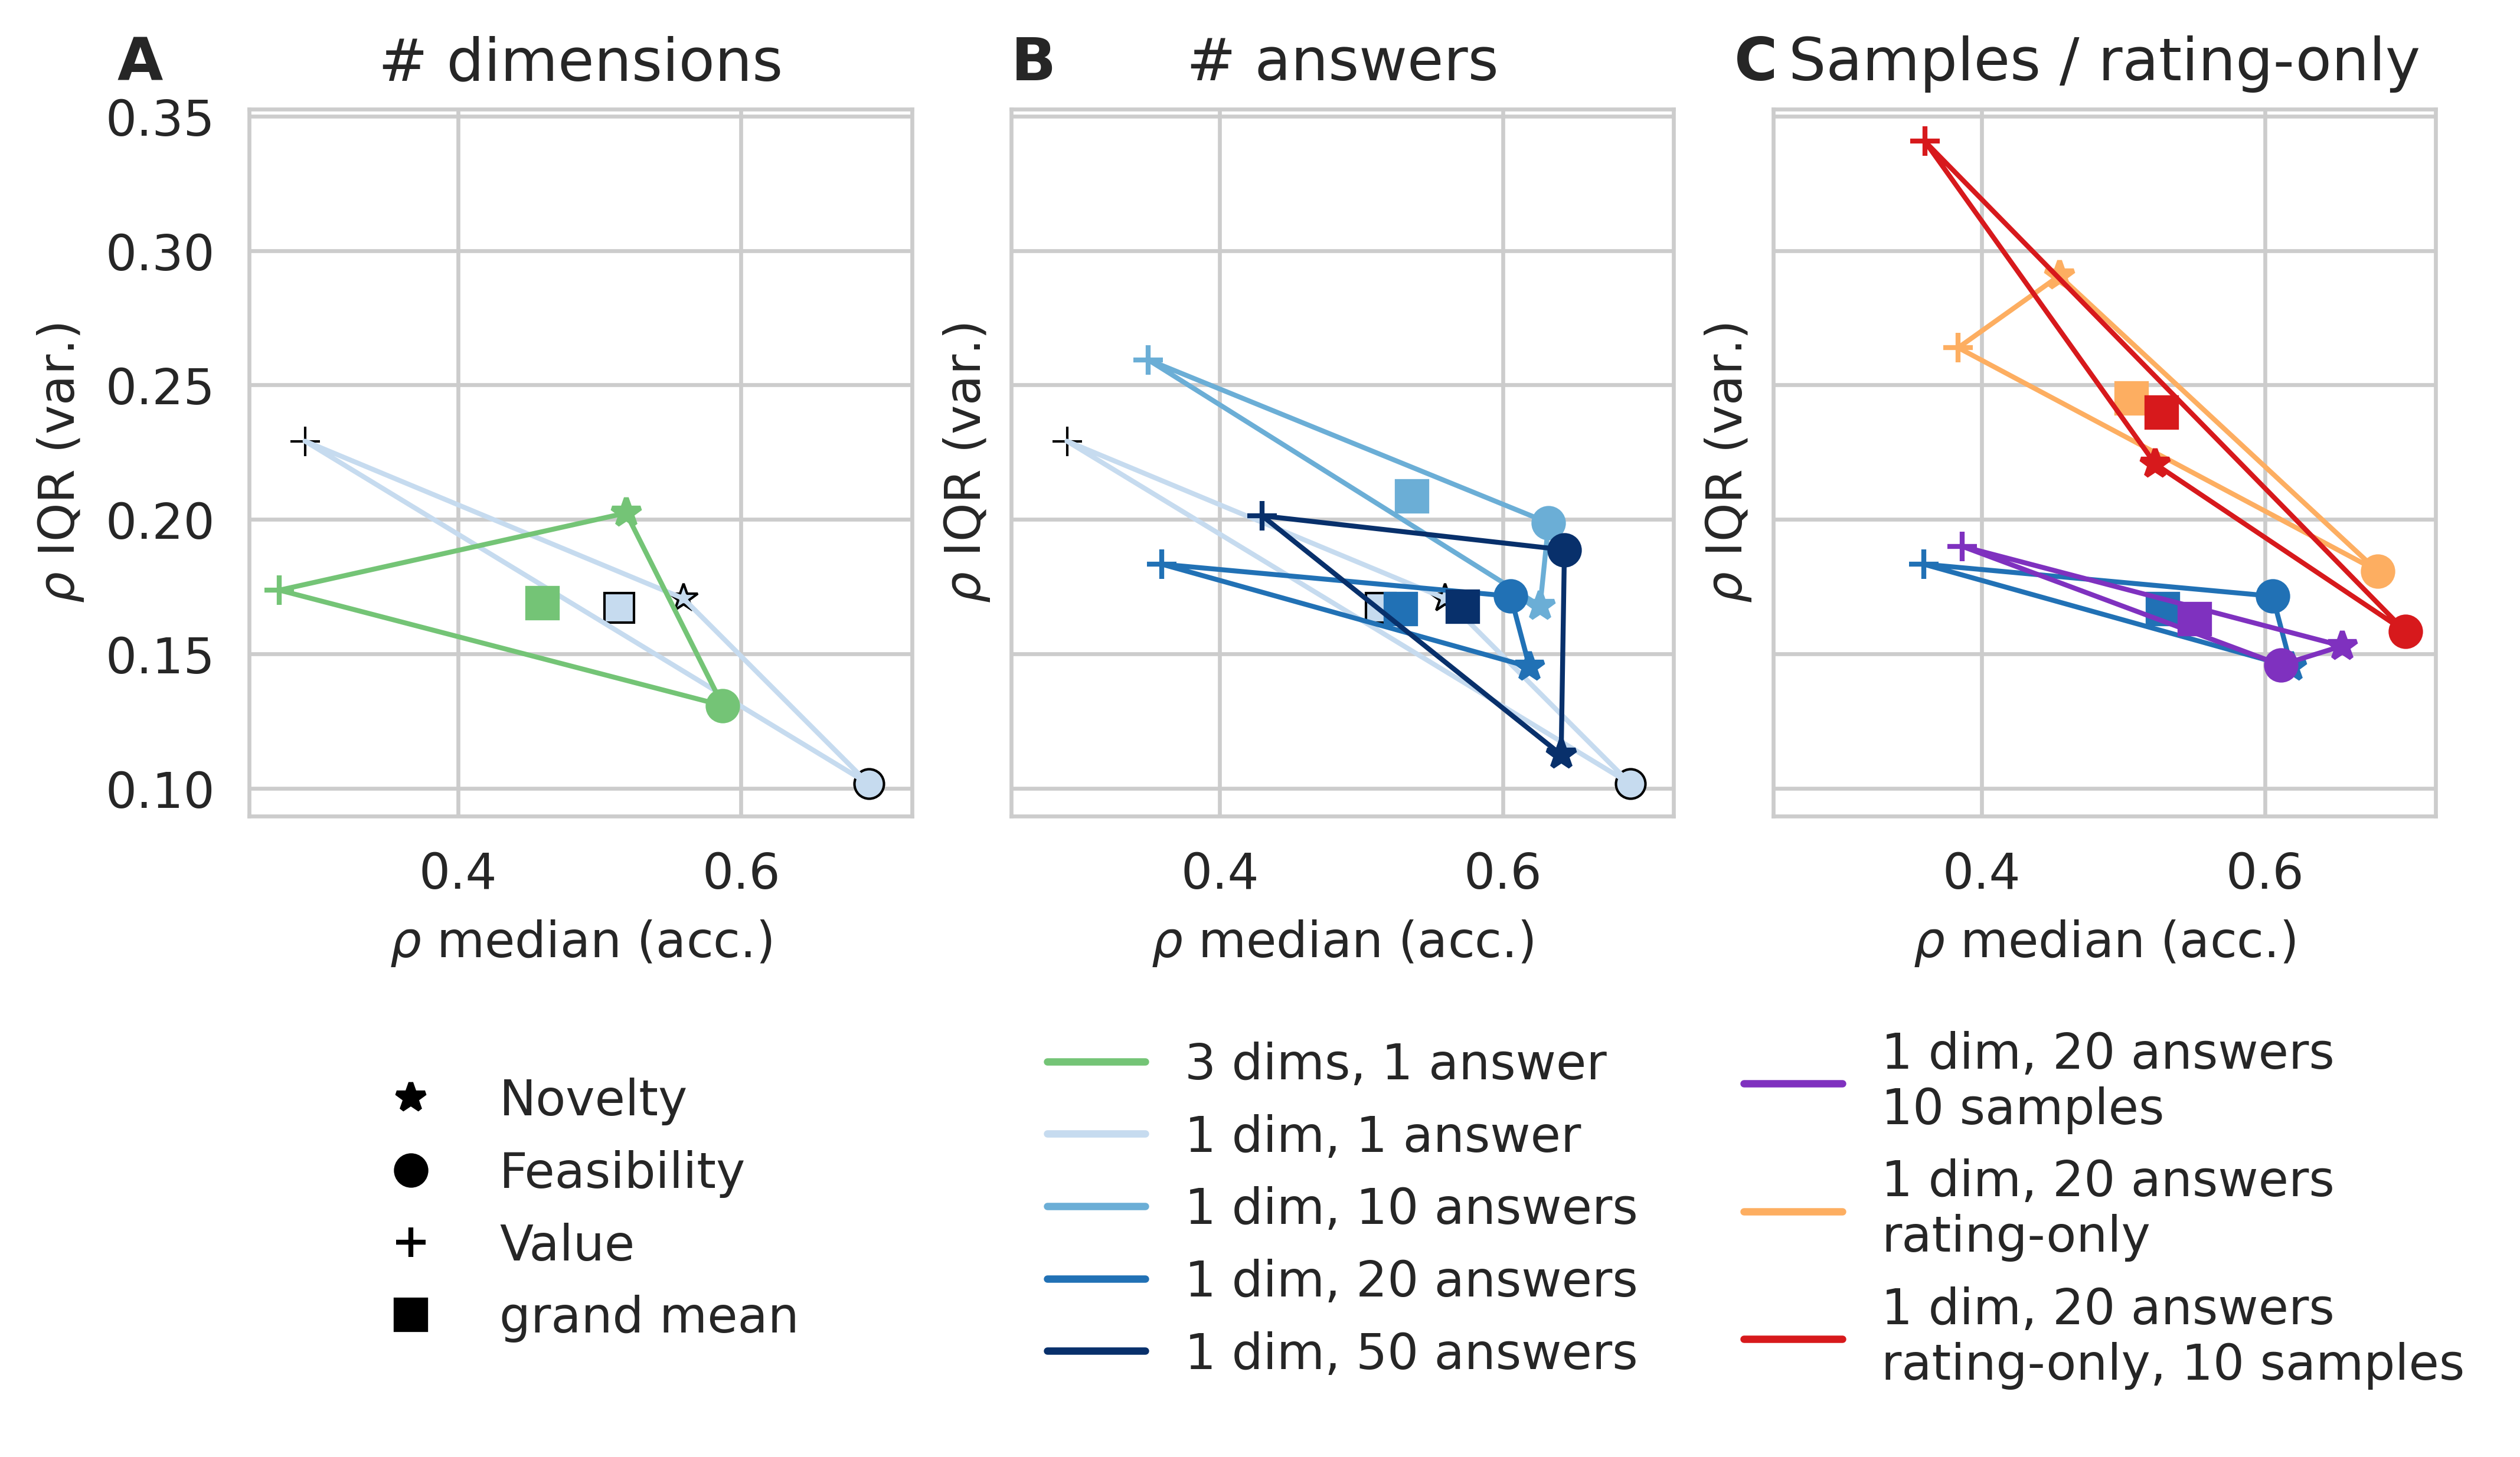

In [46]:
fig, axs = plt.subplots(2,3, figsize=(7,4), height_ratios=(1,.6), layout='constrained', dpi=600, sharex='row', sharey='row')
symbols = '*o+'
blues = ['#c6dbef', '#6baed6', '#2171b5', '#08306b']  # light to dark, 1-10-20-50
lightgreen = '#74c476'  # to match blue-1 (but darker)
purple = '#7f31bf'  # to match blue-20
reds = ['#fdae61', '#d7191c']  # light, dark
colors = {
    'n_3r1i': lightgreen,
    **{f'n_1r{x}i': c for x, c in zip((1,10,20,50), blues)},
    **{f'{t}_1r20i_numeric': c for t, c in zip('ns', reds)},
    's_1r20i': purple
}
    
for iax, (ax, (comp, title)) in enumerate(zip(axs[0], comparisons.items())):
    ax.set_title(short_titles[title])
    plot_utils.label_panel(ax, iax)
    ax.set_xlabel('$\\rho$ median (acc.)')
    ax.set_ylabel('$\\rho$ IQR (var.)')
    # ax.set_xlabel('$\\rho$ mean (acc.)')
    # ax.set_ylabel('$\\rho$ stddev')
    
    for method in comp:
        label = methods[method]
        id = list(methods.keys()).index(method)
        edge_kw = {'mec': 'k', 'mew': 0.5} if method=='n_1r1i' else {}

        accuracy, variability = [], []
        for measure, m in zip(measures, symbols):
            grouped = spearman_qid.groupby('method')[measure]
            accuracy.append(grouped.median()[label])
            variability.append(grouped.quantile(.75)[label] - grouped.quantile(.25)[label])
            # accuracy.append(grouped.mean()[label])
            # variability.append(grouped.std()[label])
            ax.plot(accuracy[-1], variability[-1], m, c=colors[method], **edge_kw)
        
        center_of_gravity = np.mean(accuracy), np.mean(variability)
        ax.plot(*center_of_gravity, 's', c=colors[method], **edge_kw)

        accuracy.append(accuracy[0])
        variability.append(variability[0])
        
        ax.plot(accuracy, variability, c=colors[method], lw=1)

for measure, m in zip(measures, symbols):
    axs[1,0].plot([], m, c='k', label=measure.capitalize())
axs[1,0].plot([], 'sk', label='grand mean')

for i, (method, title) in enumerate(methods.items()):
    axs[1, 1 + int(i>4)].plot(
        [], c=colors[method], label=title.replace('\n',', ').replace('answers, ', 'answers\n'))

for ax in axs[1]:
    ax.legend(loc='center', frameon=False)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])